<a href="https://colab.research.google.com/github/bartianbosch/Melk/blob/main/Big_Data_Milk_Oscar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Big Data Groupwork Milk


In [51]:
## To download and update the necessary requirements initialize Apache Spark, run this cell
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://downloads.apache.org/spark/spark-2.4.7/spark-2.4.7-bin-hadoop2.7.tgz
!tar xf spark-2.4.7-bin-hadoop2.7.tgz
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.7-bin-hadoop2.7"

import findspark
findspark.init()
from pyspark.sql import SparkSession
sp = SparkSession.builder.master("local[*]").getOrCreate()

from pyspark import SparkContext
from pyspark.sql import SparkSession
sc = SparkContext.getOrCreate()
spark = SparkSession.builder.getOrCreate()

from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

# Added our own necessary imports 
import seaborn as sns

from pyspark import SparkFiles

import pandas as pd
import matplotlib.pyplot as plt
plt.close('all')
plt.rcParams['figure.figsize'] = [30, 20]

from pyspark.sql import types
from pyspark.sql import functions as psf
from pyspark.sql.functions import col, unix_timestamp, to_date
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoderEstimator

from pyspark.ml import Pipeline

from pyspark.ml.regression import LinearRegression, LinearRegressionModel

from pyspark.ml.evaluation import RegressionEvaluator

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator


# Mounting drive
from google.colab import drive
drive.mount('/content/gdrive/')

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:13 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Fetched 252 kB in 2s (143 kB/s)
Reading package lists... Done
Drive already mounted at /content/gdr

Loading the data into a DF


In [45]:
## Loading the data

# Downloading the preprocessed datafile from the github in raw format
url = 'https://raw.githubusercontent.com/bartianbosch/Melk/main/ff_dairy_v1_preprocessed.csv'
fileName = url.split('/')[-1] #The filename is everything after "main/"

# Prepare and load the file into a spark rdd
spark.sparkContext.addFile(url)
milk_rdd = spark.read.csv(SparkFiles.get(fileName), header=True)
#milk_rdd = milk_rdd.repartitionByRange("Cow number")
print(type(milk_rdd))
print(milk_rdd.rdd.getNumPartitions())

# Also load the data to a pandas table, just in case we need it for testing.
milk_pd=pd.read_csv(url, encoding='latin1')

<class 'pyspark.sql.dataframe.DataFrame'>
1


In [3]:
# To check pandas dataframe, uncomment the following line:

#milk_pd

In [4]:
# To check spark rdd, uncomment the following line:
#milk_rdd.show(5)



---


## Creating a Machine Learning Model

### Data Preparation

In [57]:
## Fixing the RDD columns datatypes

# We need to change the datatype of each column in the rdd, to be able to
# process it correctly.

# TO-DO! FIND A WAY TO USE STRING COLUMNS IN ANALYSIS.

# Creating a function to set the given columns to the given datatype.
def fixType(datasetName, colName, dataType):
  """Takes a dataset and returns the dataset with the given column set to the given dataype"""
  return datasetName.withColumn(colName, psf.col(colName).cast(dataType))

# Preparing Lists with the column names according to which type they need to be.
allColumns = ['Cow number', 'Date', 'Barn', 'Barn part', 'Treatment', 'Lactation number', 'Days in milk', 'Day number', 'Week', 'Period (VP = preperiod, HP = trial period)', 'Period part (VP = preperiod, HP = trial period)', 'Intake basal ration (kg dm)', 'Intake total ration (kg dm)', 'Water intake (kg)', 'Concentrate intake (kg)', 'Weight (kg)', 'BCS', 'Backfat Thickness', 'Milk yield (kg)', 'Fat%', 'Protein%', 'Urea (mg/kg)', 'SCC (*1000/ml)', 'Lactose%', 'Avg Temperature (degC)', 'Air speed', 'Max temperature (degC)', 'Rumination time (min/day)', 'Avg pH', 'Avg Rumen Temperature ', 'Time pH<5,8 (h)', 'Manure consistency (1=fluid, 5= hard)', 'Manure fibre score (1=short, 5 = long)', 'Number of kernels', 'Manure sieving residu (%)', 'Manure dm (g/kg OM)', 'Manure starch (g/kg dm)', 'Urin-pH', 'Intake pre-period (kg dm)', 'Milk yield prepreriod (kg)', 'Fat% preperiod', 'Protein% preperiod', 'Fat preperiod (kg)', 'Protein preperiod (kg)', 'ECM preperiod (kg)', 'ECM (kg)', 'Crude fiber (g/day)', 'Sugar (g/day)', 'Crude protein (g/day)', 'Crude fat (g/day)', 'Starch (g/day)', 'Ca (g/day)', 'P (g/day)', 'Na (g/day)', 'Cl (g/day)', 'K (g/day)', 'Mg (g/day)', 'nXP (g/day)', 'RNB (g/day)', 'MELK (g/day)', 'NEL (g/day)', 'WDE (g/day)', 'EKB (g/day)', 'WDS (g/day)', 'SPK (g/day)', 'TPK (g/day)', 'SPE (g/day)', 'TPE (g/day)', 'plusI (/day)', 'WI (/day)', 'GP (g/day)', 'Crude fiber (g/kg dm)', 'Sugar (g/kg dm)', 'Crude protein (g/kg dm)', 'Crude fat (g/kg dm)', 'Starch (g/kg dm)', 'Ca (g/kg dm)', 'P (g/kg dm)', 'Na (g/kg dm)', 'Cl (g/kg dm)', 'K (g/kg dm)', 'Mg (g/kg dm)', 'nXP (g/kg dm)', 'RNB (g/kg dm)', 'MELK (/kg dm)', 'NEL (MJ/kg dm)', 'WDE (g/kg dm)', 'EKB (g/kg dm)', 'WDS (g/kg dm)', 'SPK (g/kg dm)', 'TPK (g/kg dm)', 'SPE (g/kg dm)', 'TPE (g/kg dm)', 'plusI (/kg dm)', 'WI (/kg dm)', 'GP (g/kg dm)']
doubleColumns = ['Intake basal ration (kg dm)', 'Intake total ration (kg dm)', 'Water intake (kg)', 'Concentrate intake (kg)', 'Weight (kg)', 'BCS', 'Milk yield (kg)', 'Fat%', 'Protein%', 'Lactose%', 'Avg Temperature (degC)', 'Air speed', 'Max temperature (degC)', 'Avg pH', 'Avg Rumen Temperature ', 'Time pH<5,8 (h)', 'Number of kernels', 'Manure sieving residu (%)', 'Manure starch (g/kg dm)', 'Urin-pH', 'Intake pre-period (kg dm)', 'Milk yield prepreriod (kg)', 'Fat% preperiod', 'Protein% preperiod', 'Fat preperiod (kg)', 'Protein preperiod (kg)', 'ECM preperiod (kg)', 'ECM (kg)']
intColumns = ['Cow number', 'Barn', 'Barn part', 'Lactation number', 'Days in milk', 'Day number', 'Week', 'Backfat Thickness', 'Urea (mg/kg)', 'SCC (*1000/ml)', 'Rumination time (min/day)', 'Manure consistency (1=fluid, 5= hard)', 'Manure fibre score (1=short, 5 = long)', 'Manure dm (g/kg OM)', 'Crude fiber (g/day)', 'Sugar (g/day)', 'Crude protein (g/day)', 'Crude fat (g/day)', 'Starch (g/day)', 'Ca (g/day)', 'P (g/day)', 'Na (g/day)', 'Cl (g/day)', 'K (g/day)', 'Mg (g/day)', 'nXP (g/day)', 'RNB (g/day)', 'MELK (g/day)', 'NEL (g/day)', 'WDE (g/day)', 'EKB (g/day)', 'WDS (g/day)', 'SPK (g/day)', 'TPK (g/day)', 'SPE (g/day)', 'TPE (g/day)', 'plusI (/day)', 'WI (/day)', 'GP (g/day)', 'Crude fiber (g/kg dm)', 'Sugar (g/kg dm)', 'Crude protein (g/kg dm)', 'Crude fat (g/kg dm)', 'Starch (g/kg dm)', 'Ca (g/kg dm)', 'P (g/kg dm)', 'Na (g/kg dm)', 'Cl (g/kg dm)', 'K (g/kg dm)', 'Mg (g/kg dm)', 'nXP (g/kg dm)', 'RNB (g/kg dm)', 'MELK (/kg dm)', 'NEL (MJ/kg dm)', 'WDE (g/kg dm)', 'EKB (g/kg dm)', 'WDS (g/kg dm)', 'SPK (g/kg dm)', 'TPK (g/kg dm)', 'SPE (g/kg dm)', 'TPE (g/kg dm)', 'plusI (/kg dm)', 'WI (/kg dm)', 'GP (g/kg dm)']
stringColumn = ['Treatment', 'Period (VP = preperiod, HP = trial period)', 'Period part (VP = preperiod, HP = trial period)']
milk_rdd2 = milk_rdd

# Setting the columns to the correct type
for colName in doubleColumns:
  milk_rdd2 = fixType(milk_rdd2, colName, "double")
for colName in intColumns:
  milk_rdd2 = fixType(milk_rdd2, colName, "int")
#milk_rdd2 = milk_rdd2.withColumn("Date", psf.col("Date").cast("date"))
milk_rdd2 = milk_rdd2.withColumn("Date",
                                 to_date(unix_timestamp(col('Date'), 'dd/MM/yy').cast("timestamp")))

# Uncomment the next line to check the schema
#milk_rdd2.printSchema()


In [59]:
## Create the vectorizer that adds the features column needed to run the machine learning pipeline

### To change on which columns the LR model is build you only need to change ###
### the 2 variables: inputColNames and labelColName ###

inputColNames = ['Protein preperiod (kg)','Crude fat (g/kg dm)','Protein%','Protein% preperiod','Fat%','Fat% preperiod']
#inputColNames = ['Water intake (kg)','Fat%', 'Protein%', 'Lactose%','Urea (mg/kg)', 'SCC (*1000/ml)']
#inputColNames = doubleColumns[0:10]
#inputColNames = intColumn
inputColNames = allColumns

labelColName = "Milk yield (kg)"
predictionColName = "Predicted " + labelColName

# Removing the label column from the input column if it ended in there on accident
if labelColName in inputColNames: inputColNames.remove(labelColName)

milk_data = milk_rdd2
# Forward fill blank values
from pyspark.sql import Window
from pyspark.sql.functions import last
import sys

# define the window
window = Window.partitionBy('Cow number').orderBy('Day number').rowsBetween(-sys.maxsize, 0)

for column in milk_data.columns:
  # define the forward-filled column
  filled_column = last(milk_data[column], ignorenulls=True).over(window)

  # do the fill 
  milk_data = milk_data.withColumn(column,  filled_column)

milk_rdd3 = milk_data
# Drop empty values (otherwise it can't work with the data)
#milk_rdd3 = milk_data.dropna(how='any', subset=inputColNames+[labelColName])

milk_rdd3.show(5)


+----------+----------+----+---------+---------+----------------+------------+----------+----+------------------------------------------+-----------------------------------------------+---------------------------+---------------------------+-----------------+-----------------------+-----------+----+-----------------+---------------+----+--------+------------+--------------+--------+----------------------+---------+----------------------+-------------------------+------+----------------------+---------------+-------------------------------------+--------------------------------------+-----------------+-------------------------+-------------------+-----------------------+-------+-------------------------+--------------------------+--------------+------------------+------------------+----------------------+------------------+--------+-------------------+-------------+---------------------+-----------------+--------------+----------+---------+----------+----------+---------+----------+----

In [60]:
# Stages for pipeline

# Index string columns
index_strings = [StringIndexer(inputCol= col, outputCol= f'{col}_index') for col in stringColumn]

# Encode string columns
encoder = OneHotEncoderEstimator(inputCols=[string_indexer.getOutputCol() for string_indexer in index_strings], 
                                 outputCols= [f'{col}_encoded' for col in stringColumn])

In [61]:
## Assembling the vectorizer
vectorizer = VectorAssembler(
    inputCols=inputColNames, 
    outputCol="features")

In [62]:
## Splitting the dataset into a training and testing portion.

# Setting a seed for reproducible results.
ourSeed = 1234  # default = 1234

# Randomly splitting the dataset (default 20% test, 80% train)
(testSetDF, trainingSetDF) = milk_rdd3.randomSplit([2.0,8.0],seed=ourSeed)

# Uncomment to cache these datasets for performance
testSetDF.cache()
trainingSetDF.cache()

DataFrame[Cow number: int, Date: date, Barn: int, Barn part: int, Treatment: string, Lactation number: int, Days in milk: int, Day number: int, Week: int, Period (VP = preperiod, HP = trial period): string, Period part (VP = preperiod, HP = trial period): string, Intake basal ration (kg dm): double, Intake total ration (kg dm): double, Water intake (kg): double, Concentrate intake (kg): double, Weight (kg): double, BCS: double, Backfat Thickness: int, Milk yield (kg): double, Fat%: double, Protein%: double, Urea (mg/kg): int, SCC (*1000/ml): int, Lactose%: double, Avg Temperature (degC): double, Air speed: double, Max temperature (degC): double, Rumination time (min/day): int, Avg pH: double, Avg Rumen Temperature : double, Time pH<5,8 (h): double, Manure consistency (1=fluid, 5= hard): int, Manure fibre score (1=short, 5 = long): int, Number of kernels: double, Manure sieving residu (%): double, Manure dm (g/kg OM): int, Manure starch (g/kg dm): double, Urin-pH: double, Intake pre-per

### Linear Regression Machine Learning Model

In [63]:
## Training a linear regression model with the default settings.

# Initialize the linear regression learner with default values for the parameters
lr = LinearRegression()

# Setting the name of the column with the values that need to be learned
# and setting the name of the column where the predicted results will be saved.
lr.setLabelCol(labelColName)\
  .setPredictionCol(predictionColName)

# Create a pipeline that performs the vectorizer and the Linear Regression
# learning model.
lr_pipeline = Pipeline(stages = index_strings + [encoder] + [vectorizer] + [lr])
#lrPipeline = Pipeline()
#lrPipeline.setStages([vectorizer, lr])

# Uncomment the next line to show if the training set was created correctly
#trainingSetDF.show(5)

# Train the model on the training set with the default settings.
lrModel = lrPipeline.fit(trainingSetDF)


+----------+----------+----+---------+---------+----------------+------------+----------+----+------------------------------------------+-----------------------------------------------+---------------------------+---------------------------+-----------------+-----------------------+-----------+----+-----------------+---------------+----+--------+------------+--------------+--------+----------------------+---------+----------------------+-------------------------+------+----------------------+---------------+-------------------------------------+--------------------------------------+-----------------+-------------------------+-------------------+-----------------------+-------+-------------------------+--------------------------+--------------+------------------+------------------+----------------------+------------------+--------+-------------------+-------------+---------------------+-----------------+--------------+----------+---------+----------+----------+---------+----------+----

Py4JJavaError: ignored

In [10]:
## Inspecting the results of the previous model

# The coefficients (i.e., weights) are as follows:
weights = lrModel.stages[1].coefficients

# The corresponding features for these weights are:
featuresNoLabel = vectorizer.getInputCols()

# Print coefficients 
list(zip(featuresNoLabel, weights))
print(list(zip(featuresNoLabel, weights)))
 
 # Print the intercept
print("Intercept: ",lrModel.stages[1].intercept)

[('Protein preperiod (kg)', 23.78510302111027), ('Crude fat (g/kg dm)', 3.1111241603910735), ('Protein%', -1.0967536798730237), ('Protein% preperiod', -9.414667394196618), ('Fat%', -2.757676994593801), ('Fat% preperiod', 2.094925606711645)]
Intercept:  -69.2267167449722


+----------------------+-------------------+--------+------------------+----+--------------+---------------+-------------------------+
|Protein preperiod (kg)|Crude fat (g/kg dm)|Protein%|Protein% preperiod|Fat%|Fat% preperiod|Milk yield (kg)|Predicted Milk yield (kg)|
+----------------------+-------------------+--------+------------------+----+--------------+---------------+-------------------------+
|                  1.15|                 35|    3.24|              3.22|2.81|          3.38|           27.6|        32.47856260676727|
|                  1.15|                 35|    3.67|              3.22| 4.0|          3.38|          17.69|       28.725322900855232|
|                  0.98|                 36|    3.04|              3.06|3.03|          3.61|          30.44|        33.14706072334869|
|                  0.98|                 35|    2.98|              3.06|3.88|          3.61|          29.41|        27.75771633834526|
|                  1.06|                 36|    2.94|  

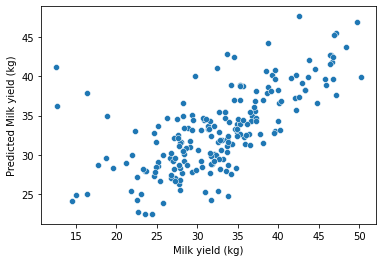

In [11]:
## Model Predictions:

 # Apply our LR model to the test data and predict power output
predictionsLR = lrModel.transform(testSetDF).select(inputColNames+[labelColName]+[predictionColName])

 # Print the first 15 rows of your predictions
predictionsLR.show(15)

#Plotting predicted against actual values to show linearity
sns.scatterplot(x=labelColName, y=predictionColName, data=predictionsLR.toPandas())

In [12]:
## Compute an evaluation metric for our test dataset

# Create an RMSE evaluator using the label and predicted columns
regEval = RegressionEvaluator(predictionCol=predictionColName, labelCol=labelColName, metricName="rmse")

# Run the evaluator on the DataFrame
rmse = regEval.evaluate(predictionsLR)

# Print the Root Mean Squared Error
print("Root Mean Squared Error: %.2f" % rmse)

Root Mean Squared Error: 5.42


In [13]:
## Compute R-squared evaluation metric for our test dataset

r2 = regEval.evaluate(predictionsLR, {regEval.metricName: "r2"})

# Print R-squard
print("r2: {0:.2f}".format(r2))

r2: 0.46


### Parameter Tuning and Evaluation

In [14]:
## Use paramater tuning to try to create a better linear regression model

# We can reuse the RegressionEvaluator, regEval, to judge the model based on the best Root Mean Squared Error
# Let's create our CrossValidator with 3 fold cross validation
crossval = CrossValidator(estimator=lrPipeline, evaluator=regEval, numFolds=3)

# Tune over our regularization parameter from 0.01 to 0.10
regParam = [x / 100.0 for x in range(1, 11)]

# Create a paramter grid using the ParamGridBuilder,
# and add the grid to the CrossValidator
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, regParam)
             .build())
crossval.setEstimatorParamMaps(paramGrid)

# Find and return the best model
cvModel = crossval.fit(trainingSetDF).bestModel

In [15]:
## Evaluate the new tuned model by comparing it to the default linear regression

# Use cvModel to compute an evaluation metric for our test dataset: testSetDF
predictionsRL = cvModel.transform(testSetDF).select(inputColNames+[labelColName]+[predictionColName])

# Run the previously created RMSE evaluator, regEval, on the predictionsAndLabelsDF DataFrame
rmseLR = regEval.evaluate(predictionsRL)

# Compute the r2 evaluation metric for our test dataset
r2LR = regEval.evaluate(predictionsRL, {regEval.metricName: "r2"})

# Printing the rounded values to compare the 2 linear regression models.
print("Original Root Mean Squared Error: {0:2.2f}".format(rmse))
print("New Root Mean Squared Error: {0:2.2f}".format(rmseLR))
print("Old r2: {0:2.2f}".format(r2))
print("New r2: {0:2.2f}".format(r2LR))

# Printing unrounded values for better testing purpose
print("\r\n","Un-rouned values printed above in same order:\r\n",rmse,rmseLR,r2,r2LR)

Original Root Mean Squared Error: 5.42
New Root Mean Squared Error: 5.42
Old r2: 0.46
New r2: 0.46

 Un-rouned values printed above in same order:
 5.42210939702948 5.420026260724854 0.4603027288199303 0.46071734495170835


# Visualization

## Plotting sample of dataset against 1 column

In [16]:
## Copy of setting the correct columns to allow easier plotting

### CHANGE inputColNames (list of x) AND LabelColName (y) TO CREATE THE
### DESIRED PLOTS. # ONLY 10 x VALUES CAN BE ENTERED AT A TIME

inputColNames = ['Protein preperiod (kg)','Fat preperiod (kg)','Crude fat (g/kg dm)','Protein%','Protein% preperiod','Fat%','Fat% preperiod']
#inputColNames = doubleColumns[0:10]

labelColName = "Milk yield (kg)"
predictionColName = "Predicted " + labelColName

# Removing the label column from the input column if it ended in there on accident
if labelColName in inputColNames: inputColNames.remove(labelColName)

# Drop empty values (otherwise it can't work with the data)
# WE MIGHT NEED TO FIND AN ALTERNATIVE TO DROPPING ANY ROW WITH BLANKS!
# CURRENTLY EXPERIMENTING WITH NOT DROPPING NA FOR THE PLOTTING
#milk_rdd3 = milk_rdd2.dropna(how='any', subset=inputColNames+[labelColName])
milk_rdd3 = milk_rdd2.select(inputColNames+[labelColName])

<Figure size 720x720 with 0 Axes>

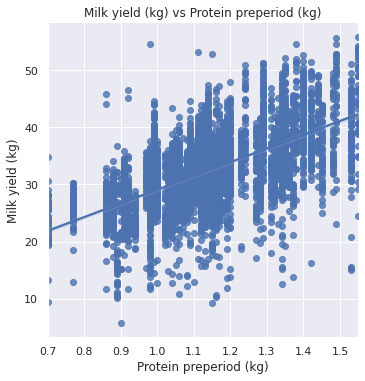

<Figure size 720x720 with 0 Axes>

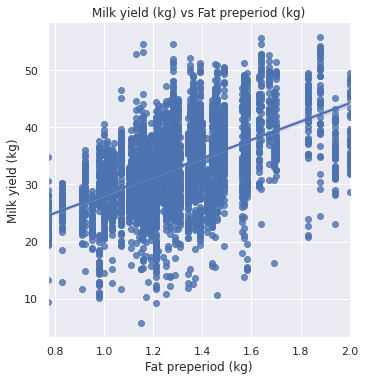

<Figure size 720x720 with 0 Axes>

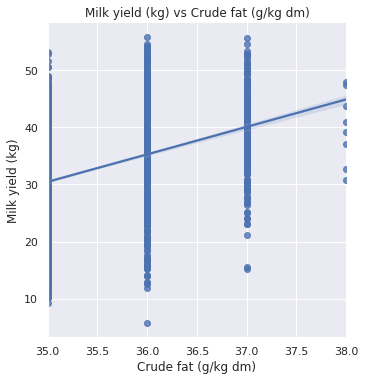

<Figure size 720x720 with 0 Axes>

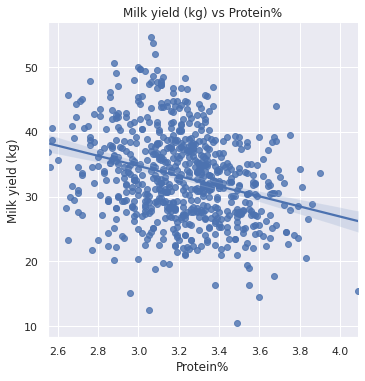

<Figure size 720x720 with 0 Axes>

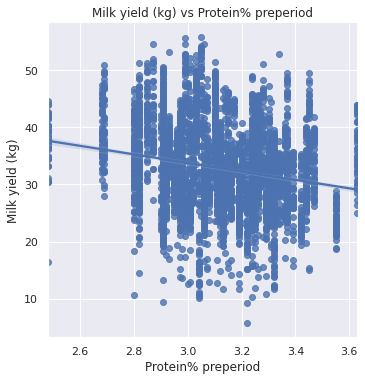

<Figure size 720x720 with 0 Axes>

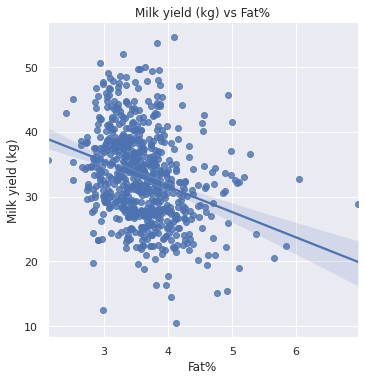

<Figure size 720x720 with 0 Axes>

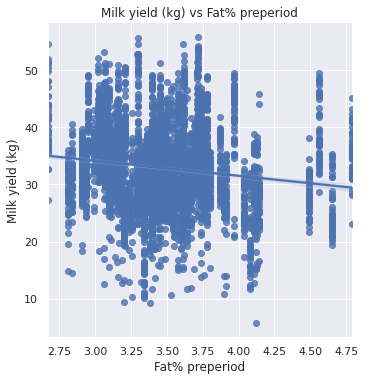

In [17]:
## Plotting the columns versus the labelcolumn to get inital idea of linear regression

### Trying to plot more than 10 plots at the same time results in empty plots ###

milk_rdd3_sample = milk_rdd3.select(inputColNames+[labelColName]).sample(False,0.5)
#print(milk_rdd3_sample)
sns.set(rc={'figure.figsize':(10,10)})

for column in inputColNames:
  plt.figure()
  sns.lmplot(x=column, y=labelColName,data=milk_rdd3_sample.toPandas())
  plt.title(labelColName+" vs "+column)
  plt.xlabel(column)
  plt.ylabel(labelColName)